In [3]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import random

# DOI 10.24432/C5HP4Z

In [4]:
nomes_colunas = ['Sample_code_number', 'Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses', 'Class']

In [5]:
df = pd.read_csv('breast-cancer-wisconsin.data')
df.columns = nomes_colunas

In [6]:
df.head()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           698 non-null    int64 
 1   Clump_thickness              698 non-null    int64 
 2   Uniformity_of_cell_size      698 non-null    int64 
 3   Uniformity_of_cell_shape     698 non-null    int64 
 4   Marginal_adhesion            698 non-null    int64 
 5   Single_epithelial_cell_size  698 non-null    int64 
 6   Bare_nuclei                  698 non-null    object
 7   Bland_chromatin              698 non-null    int64 
 8   Normal_nucleoli              698 non-null    int64 
 9   Mitoses                      698 non-null    int64 
 10  Class                        698 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [8]:
df['Class'].value_counts()

Class
2    457
4    241
Name: count, dtype: int64

In [9]:
df.drop(columns=['Sample_code_number'], inplace=True)
df.replace('?', np.nan, inplace=True)
#df = df.astype('float64')
df.dropna(inplace=True)

In [10]:
scaler = MinMaxScaler()

X = df.drop(columns=['Class'])
X = scaler.fit_transform(X)
y = df['Class']

### Divisão entre treino e teste

best val_acc: 0.977982
Seed: 28306
Melhores parâmetros encontrados: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Acc: 0.97080292

Relatório de Classificação:
               precision    recall  f1-score   support

           2     0.9885    0.9663    0.9773        89
           4     0.9400    0.9792    0.9592        48

    accuracy                         0.9708       137
   macro avg     0.9643    0.9727    0.9682       137
weighted avg     0.9715    0.9708    0.9709       137



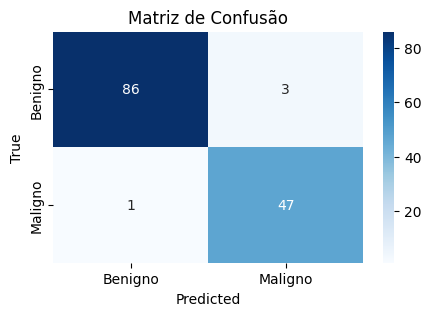

In [15]:
patience = 3
delta = 0.01
best_score = -1
counter = 0
seed_salva = None

while True:
    seed = random.randint(0, 100000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) # É bom usar stratify y pois
                                                                                                      #  as classes estão desbalanceada
    
    svm_clf = svm.SVC(kernel='rbf')
    
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Parâmetro de regularização
        'gamma': [0.001, 0.01, 0.1, 1],  # Parâmetro que define a forma da função de kernel
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Tipo de kernel
    }
    
    svm_clf = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    svm_clf.fit(X_train, y_train)
    score = svm_clf.best_score_

    # condição de parada
    if score > best_score:
        best_score = score
    elif score > best_score - delta:
        counter += 1
        if counter >= patience:
            seed_salva = seed
            break
    else:
        best_score = score
        counter = 0
        
    print(f"best val_acc: {score:.6f}", end='\r')

print("\nSeed:", seed_salva)
print("Melhores parâmetros encontrados:", svm_clf.best_params_)
#O modelo SVM com os melhores parâmetros
svm_clf = svm_clf.best_estimator_

y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Acc: %.8f" % accuracy)

class_report = classification_report(y_test, y_pred, digits=4)
print("\nRelatório de Classificação:\n", class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()